In [1]:
! pip install keras
! pip install tensorflow

In [2]:
# Importing the libraries, load the data
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("T1.csv")
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df.index=df['Date/Time']
df.drop(['Date/Time'], axis=1, inplace=True)
df.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [3]:
# Split data
train = df["Wind Speed (m/s)"].iloc[0:40424].values #40424 data as train - 80% of dataset
test = df["Wind Speed (m/s)"].iloc[40424:].values #10106 data as test 
data = df["Wind Speed (m/s)"].values

In [4]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
data = data.reshape(-1, 1)
data_set_scaled = sc.fit_transform(data)

In [5]:
# Since LSTMs store long term memory state, I create a data structure with 144 (24h) timesteps and 1 output
# So for each element of training set, I have 144 previous training set elements 
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(144,40424):
    X_train.append(data_set_scaled[i-144:i,0])
    y_train.append(data_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

# train/test data ratio = 80%/20%
for i in range(40424, 50530):
    X_test.append(data_set_scaled[i-144:i,0])
    y_test.append(data_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
print(y_test.shape)

(40280, 144)
(40280,)
(10106, 144)
(10106,)


In [6]:
# Reshaping X_train for efficient modelling from 2D to 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(40280, 144, 1)
(10106, 144, 1)


Build LSTM model

In [7]:
# define model
model = Sequential()
# first LSTM layer
model.add(LSTM(units=50, activation="relu", return_sequences=True, input_shape=(X_train.shape[1],1)))
# second LSTM layer
model.add(LSTM(units=50, activation="relu"))
# output layer
model.add(Dense(units=1))
# compile model
model.compile(optimizer="adam", loss="mean_squared_error")
# fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

Epoch 1/30
1259/1259 [==============================] - 166s 130ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 2/30
1259/1259 [==============================] - 186s 148ms/step - loss: 9.9623e-04 - val_loss: 8.8061e-04
Epoch 3/30
1259/1259 [==============================] - 155s 123ms/step - loss: 9.2994e-04 - val_loss: 8.6266e-04
Epoch 4/30
1259/1259 [==============================] - 186s 148ms/step - loss: 9.3334e-04 - val_loss: 9.1070e-04
Epoch 5/30
1259/1259 [==============================] - 239s 190ms/step - loss: 9.1431e-04 - val_loss: 9.2607e-04
Epoch 6/30
1259/1259 [==============================] - 200s 159ms/step - loss: 9.1409e-04 - val_loss: 8.9103e-04
Epoch 7/30
1259/1259 [==============================] - 210s 166ms/step - loss: 9.0594e-04 - val_loss: 8.9780e-04
Epoch 8/30
1259/1259 [==============================] - 203s 162ms/step - loss: 9.0370e-04 - val_loss: 0.0010
Epoch 9/30
1259/1259 [==============================] - 181s 144ms/step - loss: 8.9428e-04 - val_los

In [7]:
from keras.models import load_model
model = load_model('144_stacked.h5')

In [8]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [9]:
train_predict = sc.inverse_transform(train_predict)
test_predict = sc.inverse_transform(test_predict)

In [26]:
# Plot
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('Predictions')
    plt.xlabel('Time')
    plt.ylabel('Wind speed')
    plt.xlim(0,50)
    plt.legend()
    plt.show()

In [27]:
# Metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

def forecast_accuracy(true, predict):
    mape = mean_absolute_percentage_error(true, predict)
    mae = mean_absolute_error(true, predict)
    rmse = mean_squared_error(true, predict, squared=False)
    return({'mape':mape, 'mae':mae, 'rmse':rmse})

winter


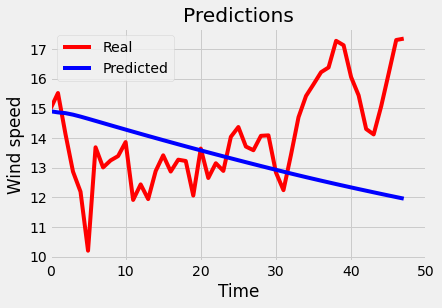

{'mape': 0.1267822246652461, 'mae': 1.8382499215550396, 'rmse': 2.375873461647705}
spring


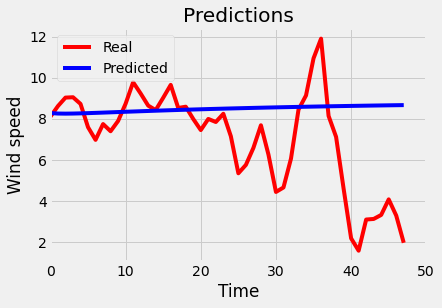

{'mape': 0.5489643765176507, 'mae': 2.0021441949150893, 'rmse': 2.85150647938357}
summer


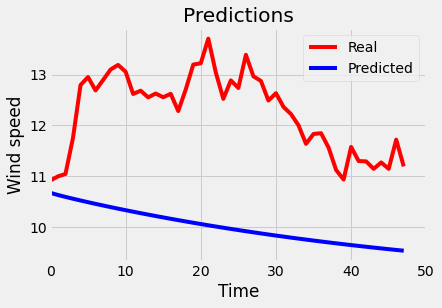

{'mape': 0.179562381147394, 'mae': 2.2334769359659536, 'rmse': 2.3504753170832986}
autumn


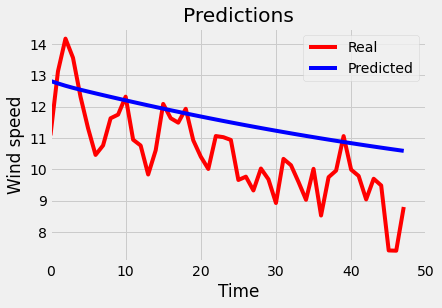

{'mape': 0.12745914634294406, 'mae': 1.2346498352174036, 'rmse': 1.4424260179676223}


In [28]:
# Predictions
winter, spring, summer, autumn = data[8640:8688], data[20000:20048], data[33000:33048], data[46000:46048]
seasons_data = [winter, spring, summer, autumn]
inputs = [data_set_scaled[8640-144:8640], data_set_scaled[20000-144:20000], data_set_scaled[33000-144:33000], data_set_scaled[46000-144:46000]]
seasons =['winter', 'spring', 'summer', 'autumn']
outputs = []

for input in inputs:
    temp_input = input
    output = []

    # predict 48 data (8h) ahead
    for i in range(48):

        if len(temp_input) == 144:
            x_input = temp_input
        else:
            # the predicted 1 output appends to inputs, so i delete the first of previous inputs
            x_input = temp_input[1:]

        x_input = x_input.reshape(1, 144, 1)
        pred_value = model.predict(x_input)
        temp_input = np.append(temp_input, pred_value[0])
        temp_input = temp_input[1:]
        output= np.append(output, pred_value[0])


    output = output.reshape(-1, 1)
    output = sc.inverse_transform(output)
    outputs.append(output)
    
for i in range(4):
    print(seasons[i])
    plot_predictions(seasons_data[i], outputs[i])
    print(forecast_accuracy(seasons_data[i], outputs[i]))